# Setup

## Installs

In [2]:
#!pip install torch==2.4.0
import torch

In [3]:
torch_version = torch.__version__
print(torch_version)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"

#!pip install torch-scatter -f $scatter_src
#!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
import torch

2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_geometric as pyg
import torch.nn as nn

## Voronoi GCA

In [136]:
# Constants
num_cells = 250
feature_size = 1 #Controls how many features we are predicting in GNN. If one-dimensional GCA then keep this one
# (density range: we flip if within density range)
lo = 0.0
hi = 0.6

batch_size = 32 #Default in Grattarola et al. is 32
#epochs = 5000
lr = 0.01



## Generating Network Topology

In [75]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d

In [137]:
# Generate 1000 points uniformly for our GCA topology
pts = np.random.uniform(0,1,(num_cells,2))

# Make voronoi diagram of points
vor = Voronoi(pts)
# Construct delaunay triangulation of cells, describing adjacency of faces
delaunay = Delaunay(pts)




Plot for safety (can skip)

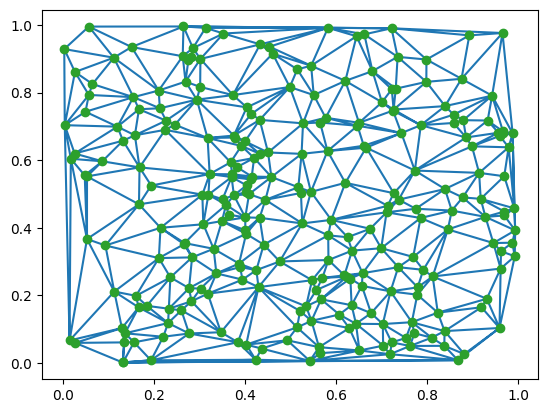

In [138]:
plt.triplot(pts[:,0], pts[:,1], delaunay.simplices)
plt.plot(pts[:,0], pts[:,1], 'o')

create edge index and corresponding adjacency matrix

In [139]:
edges = set()
for simplex in delaunay.simplices:
    edges.add(tuple(sorted((simplex[0], simplex[1]))))
    edges.add(tuple(sorted((simplex[1], simplex[2]))))
    edges.add(tuple(sorted((simplex[0], simplex[2]))))

edges = list(edges)

#Edge index
edge_index_cpu = torch.tensor(edges, dtype=torch.long).t()
edge_index = edge_index_cpu.cuda()
#print(edge_index)

In [140]:
a = np.zeros((num_cells, num_cells), dtype=int)
for i, j in edges:
    a[i, j] = 1
    a[j, i] = 1
# broadcast to gpu and normalize
a = torch.from_numpy(a).cuda().float() # Cast to float
degree_matrix = torch.diag(torch.sum(a, dim=1))
degree_matrix_inv = torch.inverse(degree_matrix) #undirected graph
a = torch.matmul(degree_matrix_inv, a)


## GCA functions

Recall our update rule is τ (si) = si if ρi in κ else 1 − si if ρi in κ
where κ = [lo,hi]


In [141]:
# Update states and batch generation]
def gca_step(adj_matrix,state):
  ''' Take one step of our GCA transition rule
  State is batch_size x num_cells matrix
  Returns: new state matrix
  '''
  # Calculate densities using state @ adj_matrix to maintain batch_size x num_cells shape
  densities = state @ adj_matrix # batch_size x num_cells matrix
  #print(f"{densities.shape} is density shape")
  #mask matrix where each row is a state's mask for what to flip
  switch_mask = (densities > lo) & (densities < hi)
  new_state = state.clone().detach()
  new_state[switch_mask] = 1 - new_state[switch_mask] # Apply mask directly
  return new_state


def get_batch():
  ''' Get our batch of states. Returns state matrix and next state matrix'''
  state = torch.randint(0,2,(batch_size,num_cells)).float().cuda()
  next_state = gca_step(a,state)
  return state, next_state

need a way to batch graphs pyg

In [142]:
def get_pyg_batch():
  ''' Generates a batch of torch_geometric.data.Batch objects for GNCA training.
  Each Data object represents a single graph instance with its x features and the global edge_index.
  '''
  data_list = [] #list of PyG data objects to batch at end
  for _ in range(batch_size):
    # Generate a random initial state for a single graph
    # state shape: (num_cells,)
    state = torch.randint(0, 2, (num_cells,)).float().cuda()

    # Reshape state to (num_cells, feature_size) for PyG Data object's x attribute
    # The feature_size is 1 in this context
    state_features = state.unsqueeze(-1)

    # Calculate the next_state for this single graph using gca_step
    # gca_step expects (batch_size, num_cells) so we unsqueeze to add a batch dimension of 1 for gca_step, then squeeze back
    next_state = gca_step(a, state.unsqueeze(0)).squeeze(0)

    #create pyg data object
    data = pyg.data.Data(x=state_features, edge_index=edge_index, y=next_state)
    data_list.append(data)

  #combine the list of Data objects into a Batch object
  return pyg.data.Batch.from_data_list(data_list).cuda()

# NN functions

unbatched minimal voronoi GCANN

In [15]:
import torch.nn as nn
import torch_geometric as pyg

# MINIMAL NN class!
class minimal_vor_GCANN_unbatched(torch.nn.Module):
  '''
  Model structure: GNN -> MLP {two layer, two neuron -> one neuron, sigmoid output}
  '''
  def __init__(self):
    super(minimal_vor_GCANN, self).__init__()

    # Model layer params
    self.input_dim = 2 #Density + Current State
    self.hidden_dim = 2
    self.output_dim = 1
    self.feature_size = 1

    # Post processing layer
    self.mlp_post = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        ).cuda()

  def forward(self,x,a):
    ''' Forward pass of most basic GNCA for simple CA on voronoi topology'''
    # Calculate densities using the pre-calculated and normalized adjacency matrix 'a'
    # 'a' is a global variable and should be on the same device as 'x' and the model
    densities = x @ a # batch_size x num_cells matrix
    # The model expects input shape (batch_size, num_cells, input_dim)
    # Reshape densities and x to (batch_size, num_cells, 1) and concatenate
    densities = densities.unsqueeze(-1)
    x = x.unsqueeze(-1)
    mlp_input = torch.cat([densities, x], dim=2) # Concatenate along the last dimension

    # Apply MLP to each node's features across the batch
    # Reshape mlp_input to (batch_size * num_cells, input_dim) for MLP
    mlp_input_reshaped = mlp_input.view(-1, self.input_dim)
    # Add print statement for debugging
    out_reshaped = self.mlp_post(mlp_input_reshaped)

    # Reshape output back to (batch_size, num_cells, output_dim)
    out = out_reshaped.view(x.size(0), x.size(1), self.output_dim)

    return out.squeeze(-1) # Squeeze the last dimension if output_dim is 1

In [16]:
import torch.nn as nn
import torch_geometric as pyg

# MINIMAL NN class!
class minimal_vor_GCANN(torch.nn.Module):
  '''
  Model structure: GNN -> MLP {two layer, two neuron -> one neuron, sigmoid output}
  '''
  def __init__(self):
    super(minimal_vor_GCANN, self).__init__()

    # Model layer params
    self.input_dim = 1
    self.hidden_dim = 2 #Density + Current State
    self.output_dim = 1
    self.feature_size = 1

    #Conv layer
    self.conv = pyg.nn.GeneralConv(self.input_dim, self.input_dim,aggr="mean",bias=False)

    #Activation of conv
    self.act = nn.Sigmoid()

    # Post processing layer
    self.mlp_post = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        ).cuda()

  def forward(self,data):
    ''' Forward pass of most basic GNCA for simple CA on voronoi topology'''
    # Calculate densities using the pre-calculated and normalized adjacency matrix 'a'
    # 'a' is a global variable and should be on the same device as 'x' and the model
    #densities = x @ a # batch_size x num_cells matrix
    # The model expects input shape (batch_size, num_cells, input_dim)
    # Reshape densities and x to (batch_size, num_cells, 1) and concatenate
    #densities = densities.unsqueeze(-1)
    x = data.x
    edges = data.edge_index
    #x = x.unsqueeze(-1)
    messages = self.conv(x,edge_index)
    messages = self.act(messages)
    #print(f"messages shape is {messages.shape}")
    mlp_input = torch.cat([messages, x], dim=-1) # Concatenate along the last dimension
    #print(f"mlp_input shape is {mlp_input.shape}")

    # Apply MLP to each node's features across the batch
    # Reshape mlp_input to (batch_size * num_cells, input_dim) for MLP
    #mlp_input_reshaped = mlp_input.view(-1, self.input_dim)
    # Add print statement for debugging
    out = self.mlp_post(mlp_input)

    return out.squeeze(-1) # Squeeze the last dimension if output_dim is 1

## A general PyG-compatible implementation of GCNAs

GCA: $(G,S,N,\tau)$ gives update fn based on neighbours of a cell:
$$\tau (s_{\mathbf{i}}):\{s_i\}\cup\{s_j|j\in N(i)\}\mapsto s_i'$$

GNN uses a message passing scheme that computes vector $\mathbf{h}_i'\in R^{d'_h}$ using (for Grattola et al.'s paper):
$$\mathbf{h_i'}=\mathbf{h}_i\|\sum_{j\in N(i)}\text{ReLU}(\mathbf{Wh}_j+\mathbf{b})$$
where $\|$ is concatenation.

Now, for a GNCA, consider a setting where the state transition function of a generic GCA is implemented with a GNN.

Our current simpler class has update rule
$\mathbf{h}_i'\in R^{d'_h}$ using (for Grattola et al.'s paper):
$$\mathbf{h_i'}=\mathbf{h}_i\|\text{ReLU}\big{(}\sum_{j\in N(i)}(\mathbf{Wh}_j+\mathbf{b})\big{)}$$

Perhaps this explains high loss

The first cell below is *unbatched* implementation and is buggy. May delete later

In [ ]:
import torch.nn as nn
import torch_geometric as pyg
import torch.nn.functional as F # Import F for ReLU

class GNCA(torch.nn.Module):
  ''' General GNCA class, generalizable for many problem types
  Architecture:
    1. MLP on node embedding
    2. Concatenation with NN on neighbors (GCN)
    3. Postprocessing MLP on result
  MLP pre and post have 256 size hidden units, post-processing MLP has number of units equal to state size
  Activation function of post-processing MLP is sigmoid for binary state spaces, tanh if between -1,1, and no activation otherwise
  '''
  def __init__(self,dims=None,activation='relu',batch_norm=False):
    super(GNCA, self).__init__() # Corrected super class call
    self.hidden_dim = 256
    self.activation = activation
    #We want dims to be passed in as a tuple [input_dim, output_dim]
    if dims is None:
      self.input_dim = 2 #Assume planar embedding
      self.output_dim = 2 #Assume output dim also planar
    else:
      self.input_dim = dims[0]
      self.output_dim = dims[1]

    # Now, we define our MLP layers
    self.mlp_pre = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=False),
            nn.ReLU())

    #Conv layer for neighbor aggregation - use general convolution and test against GCNconv
    self.conv = pyg.nn.GeneralConv(self.hidden_dim, self.hidden_dim,aggr="add",bias=False)
    #self.conv = pyg.nn.GCNConv(self.hidden_dim,self.hidden_dim,bias=False)

    self.mlp_post = nn.Sequential(
        nn.Linear(self.hidden_dim + self.hidden_dim, self.output_dim, bias=False), # Input dimension is sum of mlp_pre output and GCN output
        nn.Sigmoid() # Keep Sigmoid for now, can be changed based on task
    )

  def forward(self,data):
    '''Forward pass (see Grattarola et al. for details)
    Expects a torch_geometric.data.Batch object as input.
    '''
    x, edge_index = data.x, data.edge_index

    #x shape is (total_num_nodes, input_dim) from data.x, where total_num_nodes:= batchsize*num_cells
    h_x = self.mlp_pre(x) # Output shape: (total_num_nodes, hidden_dim)

    # Apply GCNConv, which correctly handles batched edge_index for stacked nodes.
    h_Nx = self.conv(h_x, edge_index) # Output shape: (total_num_nodes, hidden_dim)
    h_Nx = F.sigmoid(h_Nx) # Apply ReLU activation

    # Concatenate along the feature dimension (dim=-1 lets us concatenate arbitrary tensors)
    h_concat = torch.cat([h_x, h_Nx], dim=-1) # Output shape: (total_num_nodes, hidden_dim + hidden_dim)

    # Apply mlp_post
    out = self.mlp_post(h_concat) # Output shape: (total_num_nodes, output_dim)

    # Squeeze the last dimension if output_dim is 1, resulting in (total_num_nodes,)
    return out.squeeze(-1)

# Our class

In [294]:
from torch import Tensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj, OptTensor
from typing import Optional, Union


class GNCAConv(MessagePassing):
    """
    Graph Neural Cellular Automata convolution layer.

    Does a single GNCA update step using existing PyG MessagePassing framework.
    1. Compute messages from neighbours (MLP)
    2. Aggregate messages
    3. (Optional) concatenate original state with aggregated messages


    Args:
        in_channels (int): Input feature dimensionality (state size per node).
        out_channels (int): Output feature dimensionality.
        hidden_channels (int): Hidden layer size for message MLP. Default: 128.
        aggr (str): Aggregation scheme within message-passing('add', 'mean', 'max', 'cat'). Default: 'add'.
        persistence (bool): Whether to concatenate input state with aggregated
            messages. If True, output will be [h_i || aggregated_messages].
            Default: True.
        mlp_layers (int): Number of layers in message MLP. Default: 1.
        mp_layers (int): Number of message passing layers. Default: 1.
        activation (str): Activation function ('relu', 'tanh', 'elu', 'sigmoid'). Default: 'relu'.
        batch_norm (bool): Apply batch normalization in MLP. Default: False.
        dropout (float): Dropout probability in MLP. Default: 0.0.
        bias (bool): Use bias in linear layers. Default: True.

    Example:
        >>> conv = GNCAConv(in_channels=16, out_channels=16)
        >>> x = torch.randn(100, 16)  # 100 nodes, 16 features
        >>> edge_index = torch.randint(0, 100, (2, 500))
        >>> out = conv(x, edge_index)
        >>> out.shape
        torch.Size([100, 32])  # 16 (original) + 16 (aggregated) if persistence=True
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int = 128,
        aggr: str = 'add',
        persistence: bool = True,
        mlp_layers: int = 1,
        mp_layers: int=1,
        activation: str = 'relu',
        batch_norm: bool = False,
        dropout: float = 0.0,
        bias: bool = True,
        **kwargs
    ):
        super().__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.persistence = persistence
        self.mp_layers = mp_layers
        self.mlp_layers = mlp_layers # Store for __repr__

        # Activation function for internal layers (applied manually where needed)
        if activation == 'relu':
            self.internal_activation = nn.ReLU()
        elif activation == 'tanh':
            self.internal_activation = nn.Tanh()
        elif activation == 'elu':
            self.internal_activation = nn.ELU()
        elif activation == "sigmoid": # Sigmoid can be used internally too, though less common for hidden layers
            self.internal_activation = nn.Sigmoid()
        else:
            raise ValueError(f"Unknown activation: {activation}")

        # 1. Pre-processing MLP (applied to input 'x' before message passing starts)
        # This transforms the input feature `in_channels` to `hidden_channels`.
        preproc_mlp_modules = []
        preproc_mlp_modules.append(nn.Linear(in_channels, hidden_channels, bias=bias))
        if batch_norm:
            preproc_mlp_modules.append(nn.BatchNorm1d(hidden_channels))
        preproc_mlp_modules.append(self.internal_activation) # Always apply activation here
        if dropout > 0:
            preproc_mlp_modules.append(nn.Dropout(dropout))
        self.preproc_mlp = nn.Sequential(*preproc_mlp_modules)

        # 2. Message MLP (used in the `message` method, transforms `x_j`)
        # It takes features of `hidden_channels` (output of preproc_mlp) and outputs `hidden_channels`.
        # This MLP should *not* have a final activation within its Sequential block, as the activation
        # is applied *after* this MLP in the `message` method.
        message_mlp_modules = []
        current_in_dim = hidden_channels
        for i in range(mlp_layers):
            message_mlp_modules.append(nn.Linear(current_in_dim, hidden_channels, bias=bias))
            if batch_norm:
                message_mlp_modules.append(nn.BatchNorm1d(hidden_channels))
            if i < mlp_layers - 1: # Apply internal activation for all but the last linear layer
                message_mlp_modules.append(self.internal_activation)
                if dropout > 0: # Dropout typically applied after activation
                    message_mlp_modules.append(nn.Dropout(dropout))
            elif dropout > 0 and mlp_layers == 1: # Apply dropout if it's the only layer and dropout is needed
                message_mlp_modules.append(nn.Dropout(dropout))

            current_in_dim = hidden_channels

        # Ensure message_mlp is not empty if mlp_layers is 0 or logic creates an empty list
        #if not message_mlp_modules:
        #    message_mlp_modules.append(nn.Linear(hidden_channels, hidden_channels, bias=bias))
        #    if batch_norm:
        #        message_mlp_modules.append(nn.BatchNorm1d(hidden_channels))

        self.message_mlp = nn.Sequential(*message_mlp_modules)

        # 3. Decoder MLP (final post-processing)
        # Input dimension depends on `persistence`: hidden_channels (if no concat) or 2*hidden_channels (if concat).
        decoder_input_dim = hidden_channels * 2 if persistence else hidden_channels
        decoder_modules = []
        decoder_modules.append(nn.Linear(decoder_input_dim, out_channels, bias=bias))
        if batch_norm:
            decoder_modules.append(nn.BatchNorm1d(out_channels))

        # Final activation for the decoder
        if out_channels == 1: # Typically Sigmoid for binary output
            decoder_modules.append(nn.Sigmoid())
        else: # For other types of output, use identity or specific activation based on task
            decoder_modules.append(nn.Identity()) # No activation or specific internal activation
            # Or self.internal_activation if a non-linear activation is desired for multi-dim outputs


        self.decoder = nn.Sequential(*decoder_modules)

        self.reset_parameters()

    def reset_parameters(self):
        # Iterate over all sequential modules to reset parameters
        for module in self.preproc_mlp:
            if hasattr(module, 'reset_parameters'): module.reset_parameters()
        for module in self.message_mlp:
            if hasattr(module, 'reset_parameters'): module.reset_parameters()
        for module in self.decoder:
            if hasattr(module, 'reset_parameters'): module.reset_parameters()

    def forward(
        self,
        x: Tensor,
        edge_index: Adj,
        edge_weight: OptTensor = None,
    ) -> Tensor:
        """
        Forward pass of the GNCA layer, returns updates node features
        1. Computes messages from neighbours (message() method)
        2. Aggregates messages (aggregate() method)
        3. (Optional) concatenates original state (self) with aggregated messages

        Returns updated node features [num_nodes, out_channels] or
        [num_nodes, in_channels + out_channels] if persistence=True.
        """

        # Pre-process input features. x: [N, in_channels] -> [N, hidden_channels]
        x = self.preproc_mlp(x)

        # Store original pre-processed state if persistence is enabled
        x_orig = x.clone() if self.persistence else None

        # Perform message passing for mp_layers iterations
        # The `propagate` method calls message, aggregate, and update.
        # `aggr_out` will be [N, hidden_channels] after aggregation.
        aggr_out = x # Initialize with the pre-processed features for the first iteration
        for _ in range(self.mp_layers):
            aggr_out = self.propagate(edge_index, x=aggr_out, edge_weight=edge_weight)

         # Concatenate original state with aggregated messages if persistence is True
        if self.persistence:
            # x_orig is [N, hidden_channels], aggr_out is [N, hidden_channels]
            combined_features = torch.cat([x_orig, aggr_out], dim=-1) # [N, 2 * hidden_channels]
        else:
            combined_features = aggr_out # [N, hidden_channels]

        # Final post-processing using the decoder MLP
        out = self.decoder(combined_features) # [N, out_channels]

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor = None) -> Tensor:
        """
        Construct messages from neighbor nodes.
        i.e. activation(message_mlp(x_j))
        Note: x_j is tensor with neighbor node feats, which are already
              transformed by preproc_mlp, so they are `hidden_channels` dim.

        Returns tensor of messages to be aggregated [num_edges, hidden_channels]
        """
        # Apply message MLP (linear layers + batchnorm, no final activation within MLP itself)
        msg_transformed = self.message_mlp(x_j)
        # Apply the internal activation as per the paper's formulation for GNCA
        msg = self.internal_activation(msg_transformed)

        # CAN ALSO weight messages by edge weights (not in paper)
        if edge_weight is not None:
            msg = edge_weight.view(-1, 1) * msg

        return msg

    def aggregate(
        self,
        inputs: Tensor,
        index: Tensor,
        ptr: Optional[Tensor] = None,
        dim_size: Optional[int] = None
    ) -> Tensor:
        """
        Aggregate messages from neighbors (uses PyG's built-in aggregation)
        Default is add which is the same as the paper's formulation
        Note: inputs is tensor with messages from neighbors (from prev step)
        and index is based on PyG -> says which node each message is for

        Returns tensor of aggregated messages [num_nodes, hidden_channels]
        """
        # Use PyG's built-in aggregation (sum, mean, max, etc.) -> default is sum
        return super().aggregate(inputs, index, ptr=ptr, dim_size=dim_size)

    def update(self, aggr_out: Tensor) -> Tensor:
        """
        Update node embeddings after aggregation
        Doesn't do anything rn bc we're not using update() in the paper:
        In the basic GNCA formulation, we just return the aggregated messages
        Then the concatenation with original state happens in forward()!
        """
        return aggr_out

    def __repr__(self) -> str:
        return (
            f'{self.__class__.__name__}('
            f'{self.in_channels}, '
            f'{self.out_channels}, '
            f'hidden_channels={self.hidden_channels}, '
            f'aggr={self.aggr}, '
            f'persistence={self.persistence}, '
            f'mlp_layers={self.mlp_layers}, '
            f'mp_layers={self.mp_layers})'
        )

# Training

##Minimal Voronoi GNCA implementation

In [ ]:
def run_min_voronoi(weight_decay=0.001):
  ''' Run with ADAM optimizer, BCE loss, with optional ridge regression parameter'''
  model = minimal_vor_GCANN().cuda()
  lr = 0.001 #Change for minimal version (follows paper)
  weight_decay = 0.001 #Follow paper
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = torch.nn.MSELoss()

  def evaluate(state,next_state):
    '''Validation set'''
    # The model forward pass now takes a Batch object
    out = model(batch_data)
    loss = loss_fn(out, batch_data.y)
    return out, loss

  # History to track results in time
  history = []
  #Loss function history (match minimal implementation in paper)
  loss_hist = [] #Add loss value, and delete early values after 10,000 iters
  lr_count = 0 #integer that measures time since previous lr reset

  for epoch in range(100000): #100,000 epochs to match paper
    optimizer.zero_grad()
    # Get a batch of data using the new get_pyg_batch function
    batch_data = get_pyg_batch().cuda() #ensure batch data is on GPU

    # Model forward pass now takes the Batch object directly
    out = model(batch_data)
    #print(f"out shape is {out.shape}, y shape is {batch_data.y.shape}")
    loss = loss_fn(out, batch_data.y)

    #Reduce learning rate for convergence
    loss_hist.append(loss.item())
    if epoch-lr_count > 10000:
      #Reduce learning rate if small enough improvement
      if abs(loss_hist[0]-loss_hist[-1]) < 1e-4:
        lr = lr/10
        lr_count = epoch
        print(f"Reducing learning rate to {lr} at epoch {epoch}")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
      #sliding window of size 10k
      loss_hist = loss_hist[1:]


    # Validation set
    val_data_batched = get_pyg_batch()
    val_state,val_next_state = val_data_batched.x, val_data_batched.y
    out_val,loss_val = evaluate(val_state,val_next_state)

    history.append((loss.item(), loss_val.item()))
    #backward pass
    loss.backward()
    optimizer.step()

  print(f"Our final loss, validation loss, and accuracies are {history[-1]}")
  return history, model

In [ ]:
# Train model!
history,model = run_min_voronoi()

Reducing learning rate to 0.0001
Reducing learning rate to 1e-05
Reducing learning rate to 1.0000000000000002e-06
Reducing learning rate to 1.0000000000000002e-07
Reducing learning rate to 1.0000000000000002e-08


In [ ]:
#Plot training and validation loss wrt epochs
plt.plot([x[0] for x in history], label='Training Loss')
plt.plot([x[1] for x in history], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


98% accuracy with older MLP implementation (only passing in densities)

## GNCA implementation

In [1]:
def run_gnca_training_vor(epochs=500, lr=lr, weight_decay=0.00000):
    ''' Run GNCA training with ADAM optimizer, MSE loss on Voronoi batches'''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    #initialize GNCA with appropriate dimensions
    model = GNCAConv(feature_size, feature_size,hidden_channels=1,aggr='mean',activation='relu',mlp_layers = 0).to(device) # Move model to device
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    loss_fn = torch.nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer,
                                      mode='min', factor=0.25, patience=200)
    best_loss = float('inf')
    best_model_state = None

    def evaluate(batch_data):
        '''Validation set'''
        # The model forward pass now takes a Batch object
        out = model(batch_data.x, batch_data.edge_index) # Ensure batch_data components are used
        # Squeeze the output to match the target shape
        out = out.squeeze(-1)
        loss = loss_fn(out, batch_data.y)
        return out, loss

    # History to track results in time
    history = []

    for epoch in range(epochs):
        model.train() # Set model to training mode
        optimizer.zero_grad()

        # Get a batch of data using the new get_pyg_batch function
        batch_data = get_pyg_batch().to(device) # Ensure batch data is on GPU

        # Model forward pass now takes the Batch object directly
        out = model(batch_data.x,batch_data.edge_index)
        # Squeeze the output to match the target shape (e.g., (64000,))
        out = out.squeeze(-1)

        loss = loss_fn(out, batch_data.y)

        #save best model if best
        if loss < best_loss:
          best_loss = loss
          best_model_state = model.state_dict()

        # Backward pass and optimization
        loss.backward()
        #gradient clipping - adjustable
        #gclip_index = min(1,1/(epoch+1)%1000)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        # Validation - get a new validation batch
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            val_batch_data = get_pyg_batch().to(device)
            out_val, loss_val = evaluate(val_batch_data)

        scheduler.step(loss_val)

        history.append((loss.item(), loss_val.item()))

        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}')
            print(f'lr {optimizer.param_groups[0]["lr"]}')

    print(f"Our final loss and validation loss: {history[-1]}")
    if best_model_state is not None: model.load_state_dict(best_model_state)
    print(f"our BEST loss is {best_loss}")
    return history, model # Return model as well for further use (e.g., cache training)

NameError: name 'lr' is not defined

Training using general model

In [ ]:
# Now run voronoi training
history, model = run_gnca_training_vor(epochs=3000,lr=0.005)

Epoch [500/3000], Loss: 0.6931, Val Loss: 0.6931
lr 0.0003125
Epoch [1000/3000], Loss: 0.6932, Val Loss: 0.6931
lr 1.953125e-05
Epoch [1500/3000], Loss: 0.6932, Val Loss: 0.6932
lr 3.0517578125e-07
Epoch [2000/3000], Loss: 0.6931, Val Loss: 0.6931
lr 1.9073486328125e-08
Epoch [2500/3000], Loss: 0.6931, Val Loss: 0.6932
lr 4.76837158203125e-09


In [512]:
import gc
gc.collect()

18803

In [ ]:
#Whats the final accuracy in the model
batch = get_pyg_batch()
batch = batch.to("cuda")
x,adj,batch_tensor = batch.x,batch.edge_index,batch.batch
out = model(x,adj)
out = out.squeeze(-1)
#print(f"Our out shape is {out.shape} and our batch output shape is {batch.y.shape}")
acc = (out.round() == batch.y).float().mean()
print(f"Final accuracy: {acc}")

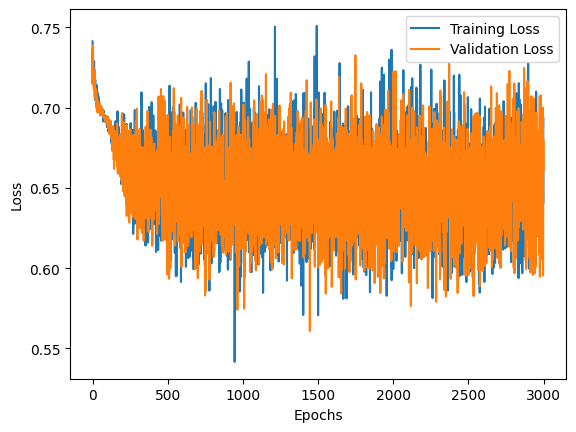

<Figure size 640x480 with 0 Axes>

In [554]:
#Plot training and validation loss wrt epochs
plt.plot([x[0] for x in history], label='Training Loss')
plt.plot([x[1] for x in history], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("loss")


In essence, the noise is a symptom of the model repeatedly trying to 'snap' its predictions to the exact 0 or 1 required by the binary GCA rule, across very sensitive boundaries in the input space. There is hope, but it requires addressing this fundamental mismatch between smooth approximation and hard thresholds.

Increase Model Capacity and Tune Scheduler: Modify the run_gnca_training_vor function (cell 166233b9) to increase the model's capacity by setting hidden_channels=8 and mlp_layers=1 in GNCAConv. Also, tune the ReduceLROnPlateau scheduler parameters to factor=0.1 and patience=50 to make it more reactive. We'll also set weight_decay=0.0001 and simplify gradient clipping to max_norm=1.0. The lr will be set to 0.001.
Execute Training with Increased Capacity and Tuned Scheduler: Execute cell YL0aeqnBffyy to run the run_gnca_training_vor function with the updated model configuration and scheduler parameters. We will also set epochs=5000 to give the model more time to converge.
Analyze Training Results for Noise Reduction: After training is complete, re-execute the cells responsible for plotting the training and validation loss (cell 86q533budgJY) and calculating the final accuracy (cell q40haofhpSM3). We will analyze the new loss curves to see if the noise has been reduced and if convergence has improved, and evaluate the final accuracy.
Final Task: Evaluate the new loss plots and accuracy, and summarize whether the changes have successfully reduced the noise and improved the model's overall learning and stability.


#produce gif


In [133]:
print(out.round())
print(batch.y)

tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 0., 1., 1.], device='cuda:0')


In [85]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(edge_index.T.tolist())
#rounded node information
batch_size = 1
pts = get_pyg_batch().x
out = model(pts,edge_index)
node_map = {node: out[node] for node in G.nodes()}
node_color = [node_map[node] for node in G.nodes()]

In [ ]:
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
# Convert node_color (which is a list of CUDA tensors from kwoZxvrmThT9) to a CPU numpy array for plotting
node_color_cpu_numpy = torch.tensor([n.item() for n in node_color]).cpu().numpy()
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color_cpu_numpy)
plt.show()

In [ ]:
#Printing 50 identical graphs with process over graphs
import networkx as nx
G = nx.Graph()
G.add_edges_from(edge_index.T.tolist())
#rounded node information
batch_size = 1
pts = get_pyg_batch().x
pos = nx.spring_layout(G)
for i in range(50):
  pts = model(pts,edge_index)
  pts = pts.round()
  node_map = {node: pts[node] for node in G.nodes()}
  node_color = [node_map[node] for node in G.nodes()]
  plt.figure(figsize=(7, 7))
  # Convert node_color (which is a list of CUDA tensors from kwoZxvrmThT9) to a CPU numpy array for plotting
  node_color_cpu_numpy = torch.tensor([n.item() for n in node_color]).cpu().numpy()
  nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color_cpu_numpy)
  plt.show()